<a href="https://colab.research.google.com/github/BengiNouri/Project2/blob/main/segmented_ml_bdh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/new_car_data_dbh123.csv')

In [ ]:
columns_to_replace = ['GPS', 'Trailer Hitch', '4WD', 'Parkingsensor', 'Cruise Control', 'Antispin', 'ESP', 'El-SÃ¦der', 'Leather Interior', 'Glass Roof', 'Headup Display', 'Isofix', 'KlimaanlÃ¦g', 'Regnsensor', 'Soltag', 'Sports Package', 'Seatwarmer', 'Xenon Lights', 'Non-Smoker', 'One-Owner', 'Service OK', 'Nysynet', 'Demo Car', 'Partly Leather Interior', 'CVR/Engros', 'Full Leather', 'Adaptive Cruise Control']  # Specify the columns you want to replace values in
data[columns_to_replace] = data[columns_to_replace].replace({'Yes': 1, 'No': 0})

In [ ]:
# Make vector of features for modelling
selected_features = data.columns.tolist()
# Remove the columns from our vector that are not meant to be used for modelling
selected_features.remove('Price')
selected_features.remove('Link')
selected_features.remove('Segment')


In [ ]:
p_data = data[data['Segment'] == 'Premium']


# Perform the train-test split on the luxury segment
pX_train, pX_test, py_train, py_test = train_test_split(
    p_data[selected_features],
    p_data['Price'],
    test_size=0.2,  # 20% of the data will be used for testing
    random_state=42  # Ensures reproducibility of the split
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(pX_train)
X_test_scaled = scaler.transform(pX_test)

# Create and train the KNN model
knn = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train_scaled, py_train)

# Make predictions
predictions = knn.predict(X_test_scaled)

# Evaluate the model
r_squared = r2_score(py_test, predictions)
mae = mean_absolute_error(py_test, predictions)
rmse = np.sqrt(mean_squared_error(py_test, predictions))

# Print the performance metrics
print(f"R² Score: {r_squared}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

In [ ]:
# Baseline xgboosting without parameters # 6 sec
xgb_model = XGBRegressor(n_estimators=600)
xgb_model.fit(pX_train, py_train)
predictions_xgb = xgb_model.predict(pX_test)

#Metrics
r_squared = r2_score(py_test, predictions_xgb)
mae = mean_absolute_error(py_test, predictions_xgb)
mse = mean_squared_error(py_test, predictions_xgb)
rmse = np.sqrt(mse)
#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': pX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))

R-squared: 0.7564780044687844
Mean Absolute Error: 30951.584800119334
Mean Squared Error: 2256029850.9678907
Root Mean Squared Error: 47497.682585236624
Top 25 important features:
              Feature  Importance
58        Brand_Tesla    0.354467
47     Brand_Mercedes    0.070936
33         Brand_Audi    0.033858
34          Brand_BMW    0.032796
31         Horsepower    0.024148
654      Fuel_Type_El    0.017912
381         Model_ID.    0.016308
653  Fuel_Type_Diesel    0.015017
40         Brand_Ford    0.014307
347      Model_GLB200    0.013837
53     Brand_Polestar    0.013467
602        Model_XC60    0.011074
316      Model_EQE350    0.010266
576        Model_V250    0.010124
253  Model_California    0.008713
60           Brand_VW    0.008372
652  Fuel_Type_Benzin    0.008339
116         Model_430    0.008253
114         Model_420    0.008214
12     Headup Display    0.007770
442     Model_Model 3    0.007344
599          Model_X5    0.006675
588        Model_Vito    0.006403
604 

In [ ]:
# XGBoosting with hyperparameters # 32 min

# Defining grid
param_grid = {
        'min_child_weight': [5, 10],
        'gamma': [0, 2],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 8, 12]
        }

xgb_model = XGBRegressor(n_estimators=600)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=0)
grid_search.fit(pX_train, py_train)
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
predictions = best_model.predict(pX_test)

#Metrics
r_squared = r2_score(py_test, predictions)
mae = mean_absolute_error(py_test, predictions)
mse = mean_squared_error(py_test, predictions)
rmse = np.sqrt(mse)
#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': pX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))

Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 1.0}
R-squared: 0.8611779330398579
Mean Absolute Error: 26771.68505618751
Mean Squared Error: 1791975842.1722767
Root Mean Squared Error: 42331.73563855227
Top 25 important features:
                     Feature  Importance
60          Gear_Automatgear    0.271548
61         Gear_Manuelt gear    0.083528
52             Brand_Porsche    0.024937
30                Horsepower    0.023986
44                  Brand_MG    0.017475
46            Brand_Mercedes    0.017227
28   Adaptive Cruise Control    0.015451
0                  KM Driven    0.014002
64          Fuel_Type_Hybrid    0.013301
4                        4WD    0.013149
17            Sports Package    0.013066
634                 Model_i3    0.012773
609               Model_XC60    0.011924
180                 Model_A6    0.011682
50                Brand_Opel    0.011072
198             Model_Arteon    0.010682
19          

Random Forest Regression Model Evaluation:
R-squared: 0.7451641653975987
Mean Absolute Error: 31868.117729950372
Mean Squared Error: 2360843211.3297076
Root Mean Squared Error: 48588.50904616962
Top 25 important features:
              Feature  Importance
31         Horsepower    0.337749
0           KM Driven    0.070852
30               Year    0.063411
1                Km/L    0.055146
47     Brand_Mercedes    0.050586
58        Brand_Tesla    0.048972
33         Brand_Audi    0.023857
18     Sports Package    0.014158
12     Headup Display    0.013897
34          Brand_BMW    0.011456
652  Fuel_Type_Benzin    0.010587
381         Model_ID.    0.008706
654      Fuel_Type_El    0.008022
13             Isofix    0.007923
4                 4WD    0.007900
11         Glass Roof    0.006676
5       Parkingsensor    0.006397
17             Soltag    0.006104
3       Trailer Hitch    0.006019
316      Model_EQE350    0.005980
114         Model_420    0.005980
602        Model_XC60    0.005

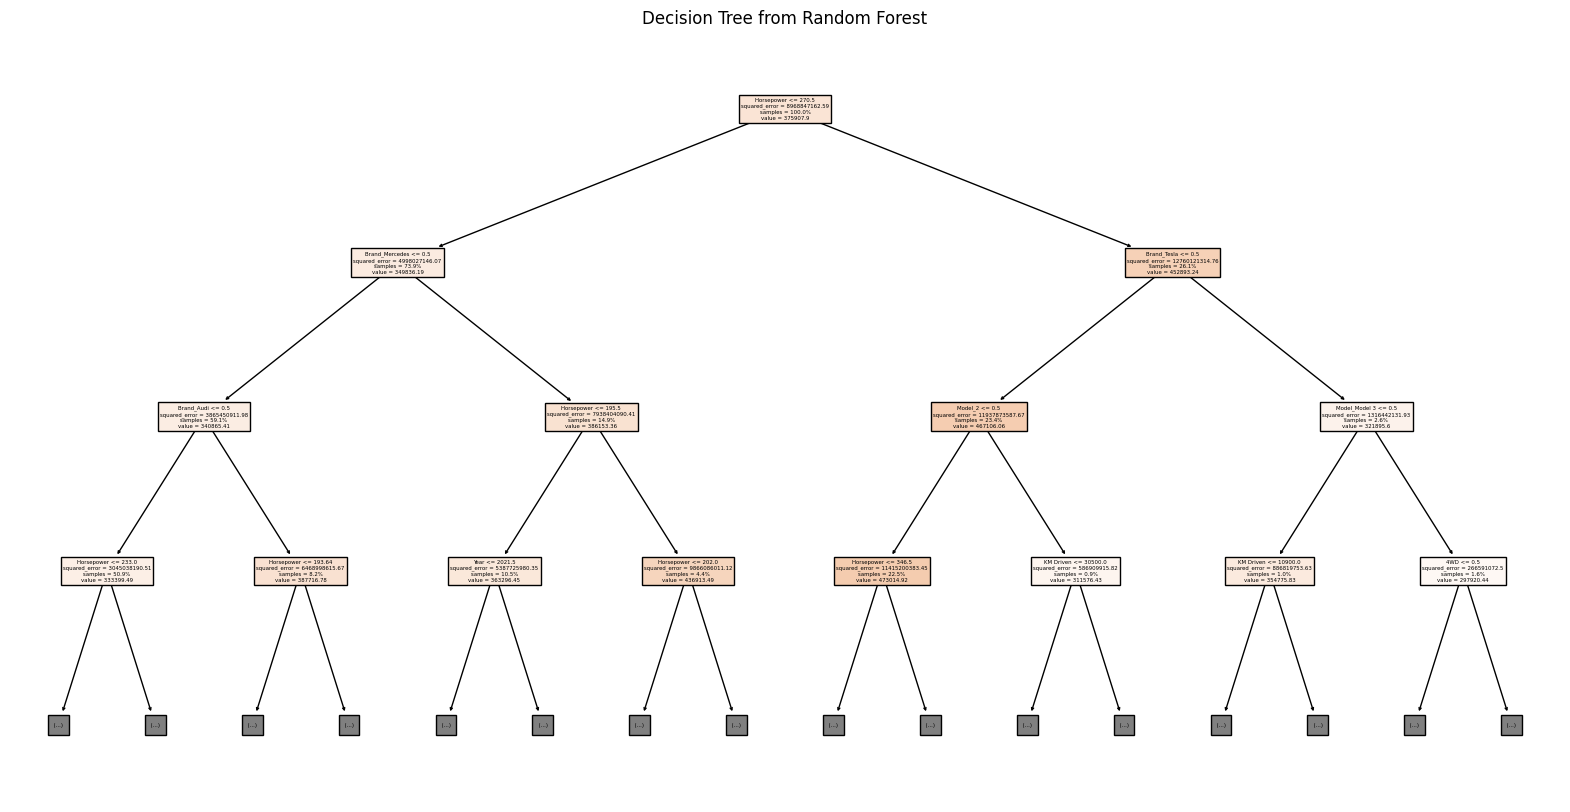

In [ ]:
# Random Forest # 2 min
rf_model = RandomForestRegressor(n_estimators=600, random_state=42)

# Train the model
rf_model.fit(pX_train, py_train)

# Make predictions on the test set
rpredictions = rf_model.predict(pX_test)

# Calculate Mean Squared Error
rr_squared = r2_score(py_test, rpredictions)
rmae = mean_absolute_error(py_test, rpredictions)
rmse = mean_squared_error(py_test, rpredictions)
rrmse = np.sqrt(rmse)

print("Random Forest Regression Model Evaluation:")
print("R-squared:", rr_squared)
print("Mean Absolute Error:", rmae)
print("Mean Squared Error:", rmse)
print("Root Mean Squared Error:", rrmse)

# Feature Importance For Random Forest
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': pX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))


# Assuming rf_model is your trained RandomForestRegressor
# Extract one tree from the forest
tree = rf_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20,10))  # Set the figure size (width, height) in inches
plot_tree(tree, filled=True, feature_names=pX_train.columns, max_depth=3, precision=2, proportion=True)
plt.title('Decision Tree from Random Forest')
plt.show()


In [ ]:
# Linear regressionsmodel # 1 sec
l_features = ['KM Driven', 'Year', 'Horsepower', 'Km/L', 'Gear_Automatgear', 'Fuel_Type_Diesel', 'Adaptive Cruise Control']
lX_train, lX_test, ly_train, ly_test = train_test_split(p_data[l_features], p_data['Price'], test_size=0.2, random_state=42)

linear_model = LinearRegression()

# Train the model
linear_model.fit(lX_train, ly_train)

# Make predictions on the test set
linear_predictions = linear_model.predict(lX_test)

# Metrics
linear_r_squared = r2_score(ly_test, linear_predictions)
linear_mae = mean_absolute_error(ly_test, linear_predictions)
linear_mse = mean_squared_error(ly_test, linear_predictions)
linear_rmse = np.sqrt(linear_mse)

print("Linear Regression Model Evaluation:")
print("R-squared:", linear_r_squared)
print("Mean Absolute Error:", linear_mae)
print("Mean Squared Error:", linear_mse)
print("Root Mean Squared Error:", linear_rmse)

Linear Regression Model Evaluation:
R-squared: 0.20808291254386313
Mean Absolute Error: 64374.67617982177
Mean Squared Error: 7336456753.712759
Root Mean Squared Error: 85653.11876232388


In [ ]:
m_data = data[data['Segment'] == 'Mid-Range']


# Perform the train-test split on the luxury segment
mX_train, mX_test, my_train, my_test = train_test_split(
    split_data[selected_features],
    split_data['Price'],
    test_size=0.2,  # 20% of the data will be used for testing
    random_state=42  # Ensures reproducibility of the split
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(mX_train)
X_test_scaled = scaler.transform(mX_test)

# Create and train the KNN model
knn = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train_scaled, my_train)

# Make predictions
predictions = knn.predict(X_test_scaled)

# Evaluate the model
r_squared = r2_score(my_test, predictions)
mae = mean_absolute_error(my_test, predictions)
rmse = np.sqrt(mean_squared_error(my_test, predictions))

# Print the performance metrics
print(f"R² Score: {r_squared}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

In [ ]:
# Baseline xgboosting without parameters # 6 sec
xgb_model = XGBRegressor(n_estimators=600)
xgb_model.fit(mX_train, my_train)
predictions_xgb = xgb_model.predict(mX_test)

#Metrics
r_squared = r2_score(my_test, predictions_xgb)
mae = mean_absolute_error(my_test, predictions_xgb)
mse = mean_squared_error(my_test, predictions_xgb)
rmse = np.sqrt(mse)
#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': mX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))

R-squared: 0.7564780044687844
Mean Absolute Error: 30951.584800119334
Mean Squared Error: 2256029850.9678907
Root Mean Squared Error: 47497.682585236624
Top 25 important features:
              Feature  Importance
58        Brand_Tesla    0.354467
47     Brand_Mercedes    0.070936
33         Brand_Audi    0.033858
34          Brand_BMW    0.032796
31         Horsepower    0.024148
654      Fuel_Type_El    0.017912
381         Model_ID.    0.016308
653  Fuel_Type_Diesel    0.015017
40         Brand_Ford    0.014307
347      Model_GLB200    0.013837
53     Brand_Polestar    0.013467
602        Model_XC60    0.011074
316      Model_EQE350    0.010266
576        Model_V250    0.010124
253  Model_California    0.008713
60           Brand_VW    0.008372
652  Fuel_Type_Benzin    0.008339
116         Model_430    0.008253
114         Model_420    0.008214
12     Headup Display    0.007770
442     Model_Model 3    0.007344
599          Model_X5    0.006675
588        Model_Vito    0.006403
604 

In [ ]:
# XGBoosting with hyperparameters # 32 min

# Defining grid
param_grid = {
        'min_child_weight': [5, 10],
        'gamma': [0, 2],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 8, 12]
        }

xgb_model = XGBRegressor(n_estimators=600)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=0)
grid_search.fit(mX_train, my_train)
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
predictions = best_model.predict(mX_test)

#Metrics
r_squared = r2_score(my_test, predictions)
mae = mean_absolute_error(my_test, predictions)
mse = mean_squared_error(my_test, predictions)
rmse = np.sqrt(mse)
#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': mX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))

Random Forest Regression Model Evaluation:
R-squared: 0.7451641653975987
Mean Absolute Error: 31868.117729950372
Mean Squared Error: 2360843211.3297076
Root Mean Squared Error: 48588.50904616962
Top 25 important features:
              Feature  Importance
31         Horsepower    0.337749
0           KM Driven    0.070852
30               Year    0.063411
1                Km/L    0.055146
47     Brand_Mercedes    0.050586
58        Brand_Tesla    0.048972
33         Brand_Audi    0.023857
18     Sports Package    0.014158
12     Headup Display    0.013897
34          Brand_BMW    0.011456
652  Fuel_Type_Benzin    0.010587
381         Model_ID.    0.008706
654      Fuel_Type_El    0.008022
13             Isofix    0.007923
4                 4WD    0.007900
11         Glass Roof    0.006676
5       Parkingsensor    0.006397
17             Soltag    0.006104
3       Trailer Hitch    0.006019
316      Model_EQE350    0.005980
114         Model_420    0.005980
602        Model_XC60    0.005

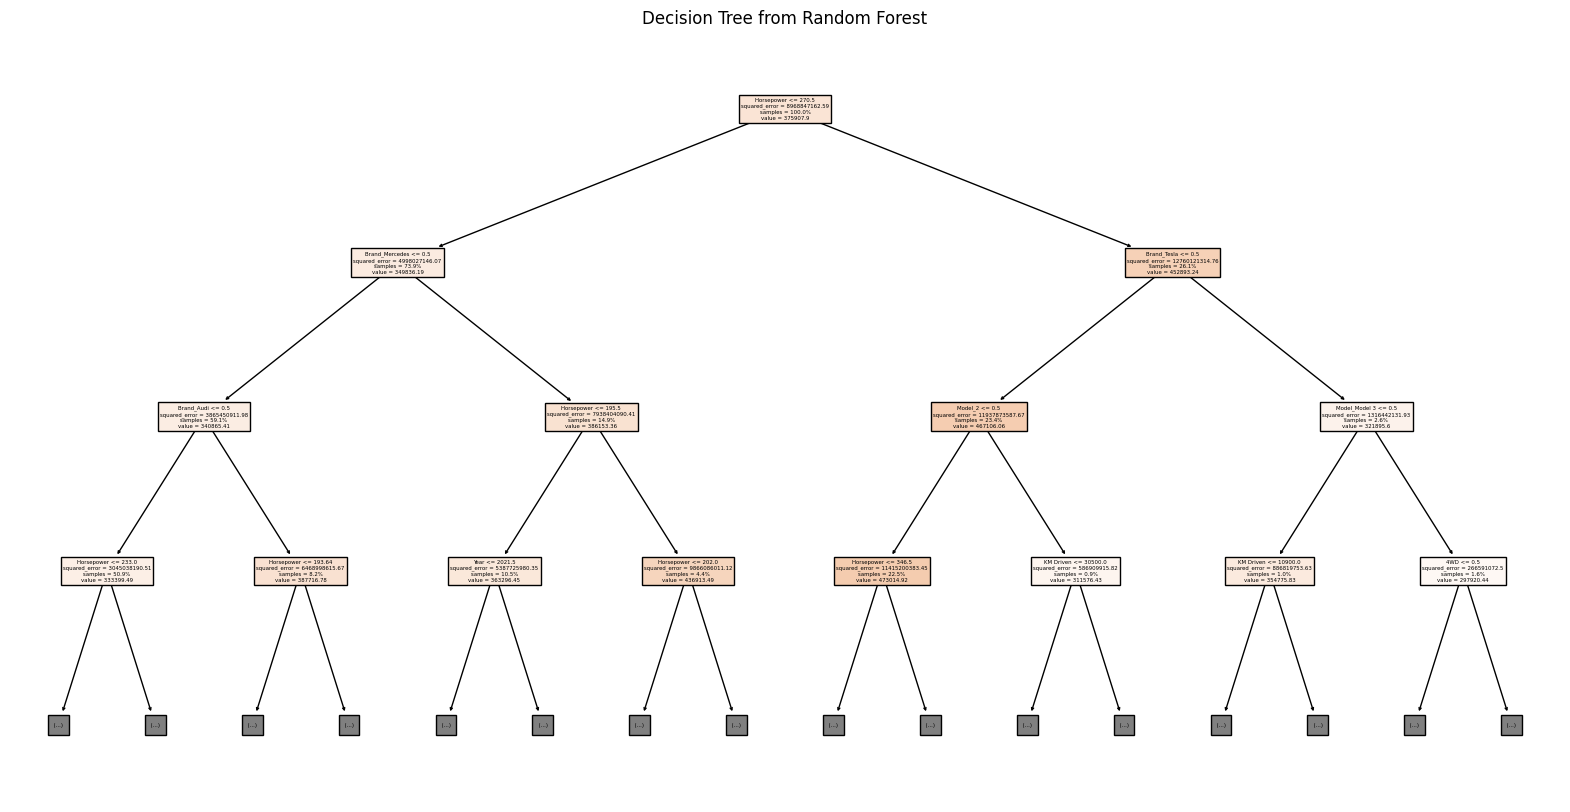

In [ ]:
# Random Forest # 2 min
rf_model = RandomForestRegressor(n_estimators=600, random_state=42)

# Train the model
rf_model.fit(mX_train, my_train)

# Make predictions on the test set
rpredictions = rf_model.predict(mX_test)

# Calculate Mean Squared Error
rr_squared = r2_score(my_test, rpredictions)
rmae = mean_absolute_error(my_test, rpredictions)
rmse = mean_squared_error(my_test, rpredictions)
rrmse = np.sqrt(rmse)

print("Random Forest Regression Model Evaluation:")
print("R-squared:", rr_squared)
print("Mean Absolute Error:", rmae)
print("Mean Squared Error:", rmse)
print("Root Mean Squared Error:", rrmse)

# Feature Importance For Random Forest
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': mX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))


# Assuming rf_model is your trained RandomForestRegressor
# Extract one tree from the forest
tree = rf_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20,10))  # Set the figure size (width, height) in inches
plot_tree(tree, filled=True, feature_names=mX_train.columns, max_depth=3, precision=2, proportion=True)
plt.title('Decision Tree from Random Forest')
plt.show()

In [ ]:
# Linear regressionsmodel # 1 sec
l_features = ['KM Driven', 'Year', 'Horsepower', 'Km/L', 'Gear_Automatgear', 'Fuel_Type_Diesel', 'Adaptive Cruise Control']
lX_train, lX_test, ly_train, ly_test = train_test_split(m_data[l_features], m_data['Price'], test_size=0.2, random_state=42)

linear_model = LinearRegression()

# Train the model
linear_model.fit(lX_train, ly_train)

# Make predictions on the test set
linear_predictions = linear_model.predict(lX_test)

# Metrics
linear_r_squared = r2_score(ly_test, linear_predictions)
linear_mae = mean_absolute_error(ly_test, linear_predictions)
linear_mse = mean_squared_error(ly_test, linear_predictions)
linear_rmse = np.sqrt(linear_mse)

print("Linear Regression Model Evaluation:")
print("R-squared:", linear_r_squared)
print("Mean Absolute Error:", linear_mae)
print("Mean Squared Error:", linear_mse)
print("Root Mean Squared Error:", linear_rmse)

Linear Regression Model Evaluation:
R-squared: 0.23707994948822864
Mean Absolute Error: 25403.68817880117
Mean Squared Error: 908495191.9159809
Root Mean Squared Error: 30141.2539871184


In [ ]:
e_data = data[data['Segment'] == 'Economy']


# Perform the train-test split on the luxury segment
eX_train, eX_test, ey_train, ey_test = train_test_split(
    e_data[selected_features],
    e_data['Price'],
    test_size=0.2,  # 20% of the data will be used for testing
    random_state=42  # Ensures reproducibility of the split
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(eX_train)
X_test_scaled = scaler.transform(eX_test)

# Create and train the KNN model
knn = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train_scaled, ey_train)

# Make predictions
predictions = knn.predict(X_test_scaled)

# Evaluate the model
r_squared = r2_score(ey_test, predictions)
mae = mean_absolute_error(ey_test, predictions)
rmse = np.sqrt(mean_squared_error(ey_test, predictions))

# Print the performance metrics
print(f"R² Score: {r_squared}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

In [ ]:
# Baseline xgboosting without parameters # 6 sec
xgb_model = XGBRegressor(n_estimators=600)
xgb_model.fit(eX_train, ey_train)
predictions_xgb = xgb_model.predict(eX_test)

#Metrics
r_squared = r2_score(ey_test, predictions_xgb)
mae = mean_absolute_error(ey_test, predictions_xgb)
mse = mean_squared_error(ey_test, predictions_xgb)
rmse = np.sqrt(mse)
#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': eX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))

R-squared: 0.8242860654267278
Mean Absolute Error: 11920.302825766834
Mean Squared Error: 280374420.8160443
Root Mean Squared Error: 16744.38475477807
Top 25 important features:
              Feature  Importance
30               Year    0.058783
31         Horsepower    0.036404
60           Brand_VW    0.029301
33         Brand_Audi    0.025404
47     Brand_Mercedes    0.023198
38        Brand_Dacia    0.022221
62   Gear_Automatgear    0.017950
432         Model_MX5    0.017560
36     Brand_CitroÃ«n    0.016765
34          Brand_BMW    0.016601
652  Fuel_Type_Benzin    0.013747
56        Brand_Skoda    0.011050
59       Brand_Toyota    0.010186
51         Brand_Opel    0.009557
288      Model_Dokker    0.009317
548    Model_Sprinter    0.008938
41        Brand_Honda    0.008910
203          Model_C1    0.008622
356       Model_GLC43    0.008498
14        KlimaanlÃ¦g    0.008250
35    Brand_Chevrolet    0.007785
122        Model_500C    0.007500
93         Model_3000    0.007419
324   

In [ ]:
# XGBoosting with hyperparameters # 32 min

# Defining grid
param_grid = {
        'min_child_weight': [5, 10],
        'gamma': [0, 2],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 8, 12]
        }

xgb_model = XGBRegressor(n_estimators=600)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=0)
grid_search.fit(eX_train, ey_train)
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
predictions = best_model.predict(eX_test)

#Metrics
r_squared = r2_score(ey_test, predictions)
mae = mean_absolute_error(ey_test, predictions)
mse = mean_squared_error(ey_test, predictions)
rmse = np.sqrt(mse)
#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': eX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))

Random Forest Regression Model Evaluation:
R-squared: 0.8026985768795204
Mean Absolute Error: 12601.342038245879
Mean Squared Error: 314820064.60061467
Root Mean Squared Error: 17743.169519581745
Top 25 important features:
               Feature  Importance
30                Year    0.459931
31          Horsepower    0.220019
0            KM Driven    0.111657
1                 Km/L    0.021415
3        Trailer Hitch    0.007051
60            Brand_VW    0.006576
5        Parkingsensor    0.006195
13              Isofix    0.006039
62    Gear_Automatgear    0.006011
63   Gear_Manuelt gear    0.005850
14         KlimaanlÃ¦g    0.005084
6       Cruise Control    0.004221
28        Full Leather    0.003989
25            Demo Car    0.003942
47      Brand_Mercedes    0.003637
24             Nysynet    0.003561
2                  GPS    0.003544
8                  ESP    0.003436
7             Antispin    0.003377
16          Regnsensor    0.003104
9            El-SÃ¦der    0.002916
19     

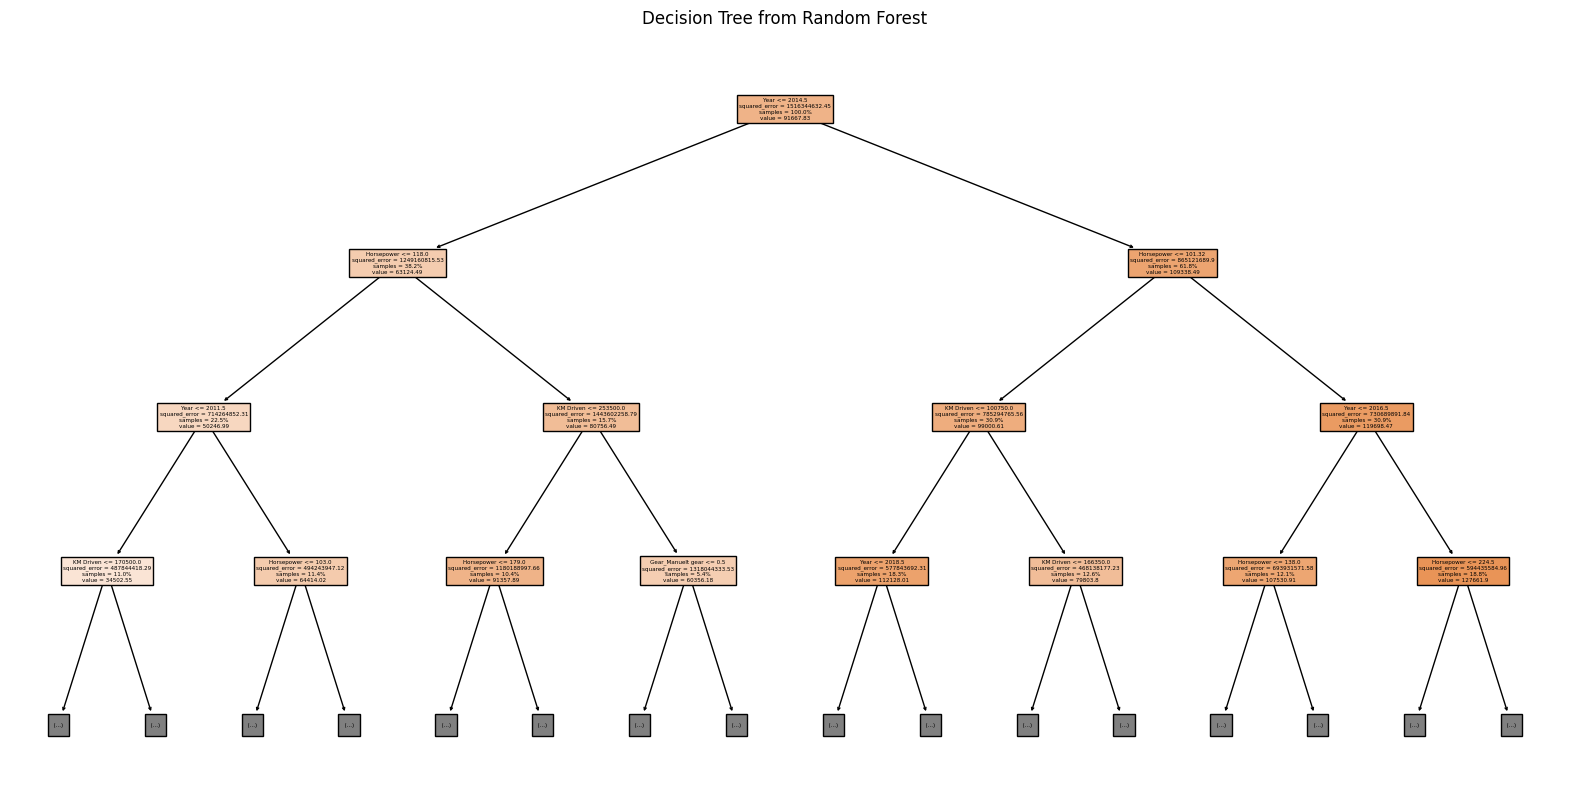

In [ ]:
# Random Forest # 2 min
rf_model = RandomForestRegressor(n_estimators=600, random_state=42)

# Train the model
rf_model.fit(eX_train, ey_train)

# Make predictions on the test set
rpredictions = rf_model.predict(eX_test)

# Calculate Mean Squared Error
rr_squared = r2_score(ey_test, rpredictions)
rmae = mean_absolute_error(ey_test, rpredictions)
rmse = mean_squared_error(ey_test, rpredictions)
rrmse = np.sqrt(rmse)

print("Random Forest Regression Model Evaluation:")
print("R-squared:", rr_squared)
print("Mean Absolute Error:", rmae)
print("Mean Squared Error:", rmse)
print("Root Mean Squared Error:", rrmse)

# Feature Importance For Random Forest
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': eX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))


# Assuming rf_model is your trained RandomForestRegressor
# Extract one tree from the forest
tree = rf_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20,10))  # Set the figure size (width, height) in inches
plot_tree(tree, filled=True, feature_names=X_train.columns, max_depth=3, precision=2, proportion=True)
plt.title('Decision Tree from Random Forest')
plt.show()


In [ ]:
# Linear regressionsmodel # 1 sec
l_features = ['KM Driven', 'Year', 'Horsepower', 'Km/L', 'Gear_Automatgear', 'Fuel_Type_Diesel', 'Adaptive Cruise Control']
lX_train, lX_test, ly_train, ly_test = train_test_split(e_data[l_features], e_data['Price'], test_size=0.2, random_state=42)

linear_model = LinearRegression()

# Train the model
linear_model.fit(lX_train, ly_train)

# Make predictions on the test set
linear_predictions = linear_model.predict(lX_test)

# Metrics
linear_r_squared = r2_score(ly_test, linear_predictions)
linear_mae = mean_absolute_error(ly_test, linear_predictions)
linear_mse = mean_squared_error(ly_test, linear_predictions)
linear_rmse = np.sqrt(linear_mse)

print("Linear Regression Model Evaluation:")
print("R-squared:", linear_r_squared)
print("Mean Absolute Error:", linear_mae)
print("Mean Squared Error:", linear_mse)
print("Root Mean Squared Error:", linear_rmse)

Linear Regression Model Evaluation:
R-squared: 0.5110781313255628
Mean Absolute Error: 21677.96134649799
Mean Squared Error: 780138388.493776
Root Mean Squared Error: 27930.957529124847
